# TAP Thermal Simulations

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import curve_fit

from gradient import thermal_gradient
from one_zone_analytics import one_zone_analytics

In [2]:
def knudsen_diffusion_coeff(temp, ref_coeff, ref_temp=298.15, ref_mass=40.0, mass=40.0):
    """Knudsen diffusion coefficient"""
    
    return ref_coeff * np.sqrt(temp * ref_mass / (ref_temp * mass))

In [3]:
def boundary_condition(time, num_molecules=1e-9, tau=1e-3):
    """Boundary condition of diffusion model"""
    
    # NOTE: Avoiding overflow
    # exp = np.exp(np.log(np.exp(time / tau)))
    
    return (num_molecules * time / (tau ** 2)) / np.exp(time / tau)

In [4]:
def plot_exit_flow(time, model, figsize=(12, 6)):
    
    plt.figure(figsize=figsize)
    plt.plot(time, model)
    
    return plt

## One zone reactor configurations

In [5]:
gridpoints = 300       

space = np.linspace(0, 0.04, gridpoints)
step_size = space[-1] / (gridpoints - 1)

## One zone temperature gradient

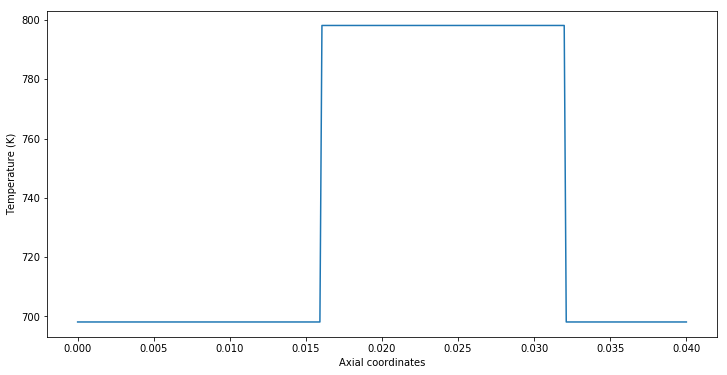

In [6]:
ref_temp = 298.15
temp_measures = [ref_temp + 400, ref_temp + 400, 
                 ref_temp + 500, ref_temp + 500, 
                 ref_temp + 400, ref_temp + 400]

gradient = thermal_gradient(space, temp_measures)

plt.figure(figsize=(12, 6))
plt.plot(space, gradient);
plt.xlabel('Axial coordinates');
plt.ylabel('Temperature (K)');

## One zone diffusion model

In [7]:
def one_zone_fd(y, time, *args, eps=0.4):
    """Converts the one-zone diffusion PDE model to ODE by finite difference scheme."""
    
    gradient = np.array(args[0], dtype=float)
    
    ref_coeff, gridpoints = float(args[1]), int(args[2])
    step_size, area =  float(args[3]), float(args[4])
    
    # Solution vector
    dydt = np.zeros(gridpoints)
    # Parameter coefficient
    phi = step_size ** 2  * eps
    
    # Reactor inlet
    for loc in [1]:
        coeff = knudsen_diffusion_coeff(gradient[loc], ref_coeff)
        
        initial_condition = 2 * step_size * boundary_condition(time) / (coeff * area)
        backward = 1 / 3 * (4 * y[loc] - y[loc + 1] + initial_condition)
        
        dydt[loc] = coeff / phi * (y[loc + 1] - 2 * y[loc] + backward) 

    # Internal grid 
    for loc in range(2, gridpoints - 2):
        sigma = knudsen_diffusion_coeff(gradient[loc], ref_coeff) / phi
        
        dydt[loc] = sigma * (y[loc + 1] - 2 * y[loc] + y[loc - 1]) 

    # Reactor outlet
    for loc in [gridpoints - 2]:
        sigma = knudsen_diffusion_coeff(gradient[loc], ref_coeff) / phi
        
        dydt[loc] = sigma * ((-2) * y[loc] + y[loc - 1]) 
        
    return dydt

In [8]:
def one_zone_numerical(time, *args, num_molecules=1e-9):
    """Returns reactor exit flow."""
    
    solu = odeint(
        one_zone_fd, np.zeros(int(space.size)), time, 
        args=args
    )
    
    ref_coeff, fstep_size, area = float(args[1]), float(args[3]), float(args[4])
    
    return solu[:, -2] * ref_coeff * area / (step_size * num_molecules)

In [9]:
# Parameters
ref_coeff = 5.e-3
area = np.pi * (0.0055 / 2) ** 2

time = np.linspace(0.0, 1.0, gridpoints)

model = one_zone_numerical(time, 
                           gradient,
                           ref_coeff, 
                           gridpoints, 
                           step_size, 
                           area)


/Users/severinlangberg/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp


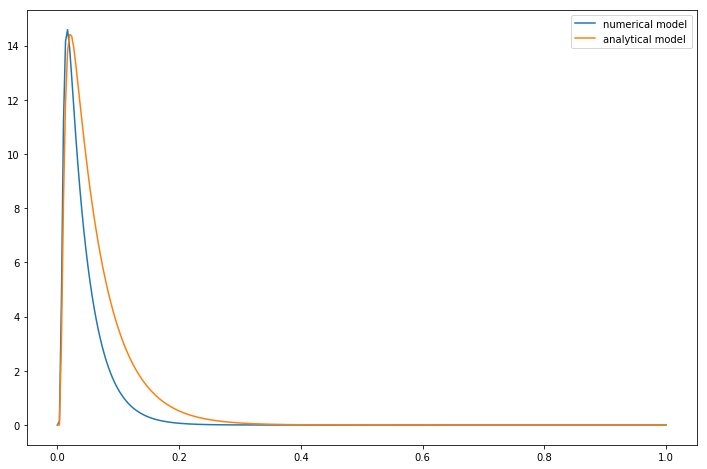

In [16]:
analytical_model = one_zone_analytics(
    dimensional=True,
    adsorption=False,
    **{
        'time': time,
        'space': space,
        'num_molecules': 1e-9,
        'eps': 0.4,
        'coeff': ref_coeff
    }
)

plt.figure(figsize=(12, 8))
plt.plot(time, model, label='numerical model')
plt.plot(time, analytical_model, label='analytical model')
plt.legend(loc='best')

## Three zone reactor configurations

In [ ]:
# Three zone reactor
gridpoints = 1e4 
zones = np.array([0.016, 0.008, 0.016], dtype=float)                             

grid = np.array(zones * gridpoints, dtype=int)          

grid_size = np.sum(grid)                        
step_size = np.sum(zones) / (grid_size - 1)  

space = np.linspace(0, np.sum(zones), grid_size)

## Three zone temperature gradient

In [ ]:
ref_temp = 298.15
temp_measures = [ref_temp + 200, ref_temp + 200, 
                 ref_temp + 300, ref_temp + 400, 
                 ref_temp + 200, ref_temp + 200]

gradient = thermal_gradient(space, temp_measures)

plt.figure(figsize=(12, 6))
plt.plot(space, gradient);
plt.xlabel('Axial coordinates (m)', fontsize=15);
plt.ylabel('Temperature (K)', fontsize=(15));

## Three zone diffusion model

In [ ]:
def _three_zone_fd(y, time, *args, eps=0.4):
    """Converts the three-zone diffusion PDE model to ODE by finite differences."""
    
    gradient = np.array(args[0], dtype=float)
    ref_coeffs = np.array(args[1], dtype=float)
    grid = np.array(args[2], dtype=int)

    step_size, area = float(args[3]), float(args[4])
    
    # Solution vector
    dydt = np.zeros(int(np.sum(grid)))
    # Parameter coefficient
    phi = step_size ** 2  * eps
    
    # Reactor inlet
    for loc in [int(1)]:
        coeff = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[0])
        
        initial_condition = 2 * step_size * boundary_condition(time) / (coeff * area)
        backward = 1 / 3 * (4 * y[loc] - y[loc + 1] + initial_condition)
        
        dydt[loc] = coeff / phi * (y[loc + 1] - 2 * y[loc] + backward) 
        
    # Internal grid zone one
    for loc in range(int(2), int(grid[0] - 1)):
        sigma = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[0]) / phi
        
        dydt[loc] = sigma * (y[loc + 1] - 2 * y[loc] + y[loc - 1]) 
    
    # Final grid point in zone one
    for loc in [int(grid[0] - 1)]:
        coeff_zone_one = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[0])
        coeff_zone_two = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        
        backward = 4 * coeff_zone_one * y[loc] - coeff_zone_one * y[loc - 1]
        forward = 4 * coeff_zone_two * y[loc + 2] - coeff_zone_two * y[loc + 3]
        zone_final = (backward + forward) / (3 * coeff_zone_one + 3 * coeff_zone_two)

        dydt[loc] = coeff_zone_one / phi * (zone_final - 2 * y[loc] + y[loc - 1])
        
    # Boundary between zone one and two
    for loc in [int(grid[0])]:
        coeff_zone_one = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[0])
        coeff_zone_two = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        
        backward = 4 * coeff_zone_one * y[loc - 1] - coeff_zone_one * y[loc - 2]
        forward = 4 * coeff_zone_two * y[loc + 1] - coeff_zone_two * y[loc + 2]
        boundary = (backward + forward) / (3 * coeff_zone_one + 3 * coeff_zone_two)

        dydt[loc] = coeff_zone_one / phi * (y[loc + 1] - 2 * boundary + y[loc - 1])
        
    # Initial grid point in zone two
    for loc in [grid[0] + 1]:
        coeff_zone_one = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[0])
        coeff_zone_two = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        
        backward = 4 * coeff_zone_one * y[loc - 2] - coeff_zone_one * y[loc - 3]
        forward = 4 * coeff_zone_two * y[loc] - coeff_zone_two * y[loc + 1]
        zone_initial = (backward + forward) / (3 * coeff_zone_one + 3 * coeff_zone_two)

        dydt[loc] = coeff_zone_two / phi * (y[loc + 1] - 2 * y[loc] + zone_initial)

    # Internal grid zone two
    for loc in range (int(grid[0] + 2), int(np.sum(grid[:2]) - 1)):
        coeff = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        
        dydt[loc] = coeff / phi * (y[loc + 1] - 2 * y[loc] + y[loc - 1])

    # Final grid point in zone two
    for loc in [int(np.sum(grid[:2]) - 1)]:
        coeff_zone_two = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        coeff_zone_three = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[2])
        
        backward = 4 * coeff_zone_two * y[loc] - coeff_zone_two * y[loc - 1]
        forward = 4 * coeff_zone_three * y[loc + 2] - coeff_zone_three * y[loc + 3]
        zone_final = (backward + forward) / (3 * coeff_zone_two + 3 * coeff_zone_three)

        dydt[loc] = coeff_zone_two / phi * (zone_final - 2 * y[loc] + y[loc - 1])
    
    # Boundary between zone two and three
    for loc in [int(np.sum(grid[:2]))]:
        coeff_zone_two = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        coeff_zone_three = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[2])
        
        backward = 4 * coeff_zone_two * y[loc - 1] - coeff_zone_two * y[loc - 2]
        forward = 4 * coeff_zone_three * y[loc + 1] - coeff_zone_three * y[loc + 2]
        boundary = (backward + forward) / (3 * coeff_zone_two + 3 * coeff_zone_three)

        dydt[loc] = coeff_zone_two / phi * (y[loc + 1] - 2 * boundary + y[loc - 1])

    # Initial grid point of zone three
    for loc in [int(np.sum(grid[:2]) + 1)]:
        coeff_zone_two = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[1])
        coeff_zone_three = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[2])
        
        backward = 4 * coeff_zone_two * y[loc - 2] - coeff_zone_two * y[loc - 3]
        forward = 4 * coeff_zone_three * y[loc] - coeff_zone_three * y[loc + 1]
        zone_initial = (backward + forward) / (3 * coeff_zone_two + 3 * coeff_zone_three)

        dydt[loc] = coeff_zone_three / phi * (y[loc + 1] - 2 * y[loc] + zone_initial)
        
    # Internal grid of zone three
    for loc in range(int(np.sum(grid[:2]) + 2), int(np.sum(grid) - 2)):
        coeff = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[2])
        
        dydt[loc] = coeff / phi  * (y[loc + 1] - 2 * y[loc] + y[loc - 1])
    
    for loc in [int(np.sum(grid) - 2)]:
        coeff = knudsen_diffusion_coeff(gradient[loc], ref_coeffs[2])

        dydt[loc] = coeff / phi * (-2 * y[loc] + y[loc - 1])
        
    return dydt

In [ ]:
def three_zone_numerical(time, *args, num_molecules=1e-9):
    """Returns reactor exit flow."""
    
    solu = odeint(
        three_zone_fd, np.zeros(int(space.size)), time, 
        args=args
    )
    print(solu[:, -2])
    ref_coeffs = np.array(args[1], dtype=float)
    step_size, area = float(args[3]), float(args[4])
    
    return solu[:, -2] * ref_coeffs[1] * area / (step_size * num_molecules)

In [ ]:
# Parameters
ref_coeffs = [5.e-3, 5.e-3, 5.e-3]
area = np.pi * (0.0055) ** 2

time = np.linspace(0.0, 1.0, gridpoints)

model = three_zone_numerical(time,  
                             gradient,
                             ref_coeffs,
                             grid, 
                             step_size, 
                             area)

plot_exit_flow(time, model)